In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple
from pprint import pprint
from tqdm import tqdm
import time
from scipy import stats
from scipy.optimize import minimize

from itertools import combinations

import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.class_weight import compute_class_weight

from BorutaShap import BorutaShap
import category_encoders as ce

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, EFeaturesSelectionAlgorithm, EShapCalcType

import optuna
from optuna.samplers import TPESampler

import tensorflow as tf  # another kernel: work in progress - MLP with BatchNorm, Convolutional

from utils import *
import gc
gc.enable()

In [2]:
seed = 42
np.random.seed(seed)
np.set_printoptions(2)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

ID_COL = 'APPLICATION_NUMBER'
TARGET= 'TARGET'

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

**models based on profile data**

In [4]:
data = pd.concat([train, test], axis=0)
df = prepare_cp_sec(data, dropna=False, create_features=True, is_category_encode=False)

df_cat_cols = [column for column in df.columns if df[column].dtype in ["object", "category"]]
for col in df_cat_cols:
    if df[col].nunique() > 20:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col].astype(str).fillna("NA"))
df, _ = get_encoded(df)

data_border = len(data) - df[TARGET].isna().sum()
data_train, data_test = df.iloc[:data_border, :], df.iloc[data_border:, :]
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]

X = X.drop(ID_COL, axis=1)

X.shape
# pay attention at EXTERNAL_WEIGHTED_SCORE: lots of NA values due to NA in additive terms (next hypothesis to fillna(0) in sum)

Memory usage of dataframe is 182.15 MB
Memory usage after optimization is: 86.31 MB
Decreased by 52.6%


(110093, 117)

In [5]:
# features, selected by BorutaShap and handy elimination
boruta = ['NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'AGE', 'NEW_CREDIT_TO_ANNUITY_RATIO', 
          'DAYS_ON_LAST_JOB', 'ANNUITY_JOB', 'RATIO_CREDIT_TO_AGE', 'RATIO_CAR_TO_EXPERIENCE', 'RATIO_CAR_TO_AGE', 
          'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'SALARY_JOB', 
          'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EXTERNAL_SCORING_RATING_3', 
          'NAME_CONTRACT_TYPE', 'CREDIT_JOB', 'AMOUNT_CREDIT', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 
          'EXTERNAL_SCORE_WEIGHTED', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'EXTERNAL_SCORING_RATING_2', 
          'EDUCATION_FAMILY_STATUS', 'GENDER', 'RATIO_ANNUITY_TO_AGE', 'TOTAL_SALARY_MIN_BY_EDUCATION', 
          'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'AMOUNT_ANNUITY', 'OWN_CAR_AGE', 'RATIO_AGE_TO_EXPERIENCE', 
          'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'EXTERNAL_SCORING_RATING_1', 
          'TOTAL_SALARY_COUNT_BY_EDUCATION', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 
          'RATIO_SALARY_TO_AGE', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'AMT_REQ_CREDIT_BUREAU_QRT', 
          'SALARY_REGION_POPULATION', 'AGE_BIN', 'TOTAL_SALARY_MAX_BY_EDUCATION', 'NEW_STATUS_FMarried', 
          'RATIO_SALARY_TO_AMOUNT_CREDIT']

**LGBM Base model (boruta features from profile.csv)**

Predictions for test are obtained by averaging CV estimators

In [6]:
# got 0.73211 on LB
lgbm_params_my = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'num_leaves': 42,
    'max_depth': 10,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 60,
    'random_state': seed
}

estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(lgbm_params_my, 
                                                            X[boruta], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                            rounds=50)

Mon Aug 29 01:18:57 2022, Cross-Validation, 110093 rows, 42 cols
Fold 1, Train score = 0.76313, Valid score = 0.74097
Fold 2, Train score = 0.78009, Valid score = 0.72522
Fold 3, Train score = 0.77006, Valid score = 0.73068
Fold 4, Train score = 0.78626, Valid score = 0.73238
Fold 5, Train score = 0.78299, Valid score = 0.71769
Train score by each fold: [0.76313, 0.78009, 0.77006, 0.78626, 0.78299]
Valid score by each fold: [0.74097, 0.72522, 0.73068, 0.73238, 0.71769]
Train mean score by each fold:0.77651 +/- 0.00861
Valid mean score by each fold:0.72939 +/- 0.00773
**************************************************
OOF-score: 0.72810


In [7]:
# this is no quite fair as we used oof values for early stopping in CV loop. CI would be optimistic
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lgbm, roc_auc_score))

(0.7228434154984971, 0.7334154541859734)

In [8]:
test_preds = np.array([model.predict_proba(data_test[boruta])[:,1] for model in estimators_lgbm])
# test_preds1 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds1 = test_preds.T.mean(axis=1)

**CatBoost Base model**

In [9]:
# 0.72989
cat_params = {
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 1000, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                #'auto_class_weights': 'SqrtBalanced',  
                'grow_policy': 'SymmetricTree', 
                'objective': 'Logloss',  
                'boosting_type': 'Ordered', 
                'score_function': 'Cosine',  
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 3.68,  
                'colsample_bylevel': 0.839,  
                'depth': 6, 
                'l2_leaf_reg': 3,  
                'learning_rate': 0.05, 
                'max_ctr_complexity': 2, 
                'subsample': 0.86,  
                'max_bin': 254,  
}
cat_cols = [column for column in X.columns if X[column].dtype in ["object", "category"]]

estimators_cat, oof_preds_cat = catboost_cross_validation(cat_params, 
                                                          X[boruta], 
                                                          y, 
                                                          cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                          rounds=50)

Mon Aug 29 01:19:26 2022, Cross-Validation, 110093 rows, 42 cols
Fold 1, Train score = 0.75819, Valid score = 0.74345
Fold 2, Train score = 0.75763, Valid score = 0.72580
Fold 3, Train score = 0.75460, Valid score = 0.72823
Fold 4, Train score = 0.75738, Valid score = 0.72935
Fold 5, Train score = 0.76206, Valid score = 0.71923
Train score by each fold: [0.75819, 0.75763, 0.7546, 0.75738, 0.76206]
Valid score by each fold: [0.74345, 0.7258, 0.72823, 0.72935, 0.71923]
Train mean score by each fold:0.75797 +/- 0.00239
Valid mean score by each fold:0.72921 +/- 0.00794
**************************************************
OOF-score: 0.72831


In [10]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_cat, roc_auc_score))

(0.7230139582496385, 0.7335391322984915)

In [11]:
test_preds = np.array([model.predict_proba(data_test[boruta])[:,1] for model in estimators_cat])
# test_preds2 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds2 = test_preds.T.mean(axis=1)

**Add Bureau features and new models**

In [12]:
bureau = bki_cr()
bureau.shape

(273131, 34)

In [13]:
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]
X = X.merge(bureau, on=ID_COL, how='left')
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)

In [ ]:
# select informative features with less overfitting params
lgbm_params = {
                'metric':"auc", 
                'boosting_type': 'goss',
                'is_unbalance': True,
                'n_estimators': 212, 
                'learning_rate': 0.01, 
                'min_child_weight': 350, 
                'min_split_gain': 0.024766,
                'max_depth': 3,
                'verbose': -1,
                'reg_alpha': 30,
                'reg_lambda': 30,
                'colsample_bytree': 0.33,
                'num_leaves': 42,
                'subsample': 0.33,
                'max_bin': 128,
                'random_state': seed
}

selector = BorutaShap(model=LGBMClassifier(**lgbm_params), importance_measure='shap', classification=True)
selector.fit(X, y, n_trials=20, sample=False, normalize=True, verbose=True)

In [14]:
boruta_bureau = ['EXTERNAL_SCORE_WEIGHTED', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'DAYS_ON_LAST_JOB', 
                 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'ANNUITY_JOB', 
                 'EXTERNAL_SCORING_RATING_2', 'AMOUNT_CREDIT', 'EXTERNAL_SCORING_RATING_3', 'AGE', 'AMOUNT_ANNUITY', 
                 'AMT_REQ_CREDIT_BUREAU_YEAR', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'RATIO_SALARY_TO_AGE', 
                 'EXTERNAL_SCORING_RATING_1', 'EXT_SCORE_3_ANNUITY', 'EXT_SCORE_3_AMT_CREDIT', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 
                 'EXT_SCORE_2_ANNUITY', 'GENDER', 'EDUCATION_LEVEL_Higher education', 'EXT_SCORE_2_AMT_CREDIT', 
                 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'TOTAL_SALARY_MIN_BY_EDUCATION', 
                 'OWN_CAR_AGE', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 'EDUCATION_FAMILY_STATUS', 'RATIO_CREDIT_TO_AGE', 
                 'NEW_STATUS_FMarried', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'RATIO_CAR_TO_AGE', 'CREDIT_JOB',
                 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 
                 'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'RATIO_CAR_TO_EXPERIENCE', 'NEW_CREDIT_TO_ANNUITY_RATIO', 
                 'RATIO_ANNUITY_TO_AGE', 'NAME_CONTRACT_TYPE', 'RATIO_AGE_TO_EXPERIENCE', 
                 'AMOUNT_ANNUITY_MEAN_BY_FAMILY_STATUS', 'TOTAL_SALARY_MAX_BY_FAMILY_STATUS', 'SALARY_JOB', 
                 'AMOUNT_CREDIT_COUNT_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMOUNT_CREDIT_COUNT_AGE_INTERVAL', 
                 'TOTAL_SALARY_MAX_AGE_INTERVAL', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'TOTAL_SALARY_MAX_BY_EDUCATION', 
                 'AMOUNT_ANNUITY_MAX_BY_FAMILY_STATUS', 'AMOUNT_CREDIT_MAX_AGE_INTERVAL', 'AGE_BIN', 'REGION_POPULATION', 
                 'TOTAL_SALARY_COUNT_BY_EDUCATION', 'BURO_CREDIT_TYPE_Consumer credit_MEAN']

**LGBM model 2**

In [15]:
# 0.73209
lgbm_params_my = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 42,
    'max_depth': 5,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 60,
    'random_state': seed
}

estimators_lgbm2, oof_preds_lgbm2 = lightgbm_cross_validation(lgbm_params_my, 
                                                              X[boruta_bureau], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed//2, shuffle=True), 
                                                              rounds=50)

Mon Aug 29 01:21:05 2022, Cross-Validation, 110093 rows, 56 cols
Fold 1, Train score = 0.76725, Valid score = 0.72320
Fold 2, Train score = 0.76841, Valid score = 0.73593
Fold 3, Train score = 0.76600, Valid score = 0.71998
Fold 4, Train score = 0.77442, Valid score = 0.72993
Fold 5, Train score = 0.77007, Valid score = 0.73611
Train score by each fold: [0.76725, 0.76841, 0.766, 0.77442, 0.77007]
Valid score by each fold: [0.7232, 0.73593, 0.71998, 0.72993, 0.73611]
Train mean score by each fold:0.76923 +/- 0.00292
Valid mean score by each fold:0.72903 +/- 0.00655
**************************************************
OOF-score: 0.72869


In [16]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lgbm2, roc_auc_score))

(0.7233100120323647, 0.7339496113680317)

In [17]:
preds = pd.DataFrame(data=np.array([model.predict_proba(X[boruta_bureau])[:,1] for model in estimators_lgbm2]).T)
mean_scores(preds, y)
# weights optimization do not improve LB

AMean score: 0.76454
GMean score: 0.76409
Rank  score: 0.76389
GMean  rank: 0.76346


In [18]:
data_test.drop(TARGET, axis=1, inplace=True)
data_test = data_test.merge(bureau, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop(ID_COL, axis=1, inplace=True)

In [19]:
test_preds = np.array([model.predict_proba(data_test[boruta_bureau])[:,1] for model in estimators_lgbm2])
# test_preds3 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds3 = test_preds.T.mean(axis=1)

In [29]:
test_preds3.to_csv('submission.csv', index=False)
#!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  4%|4         | 216k/4.90M [00:00<00:02, 1.65MB/s]
 38%|###7      | 1.85M/4.90M [00:00<00:00, 3.67MB/s]
 93%|#########2| 4.55M/4.90M [00:00<00:00, 9.04MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 2.34MB/s]


**CatBoost model 2**

In [20]:
# 0.73096
cat_params2 = {
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 2000, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                'grow_policy': 'SymmetricTree', 
                'objective': 'Logloss',  
                'boosting_type': 'Ordered', 
                'score_function': 'Cosine',  
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 3.68,  
                'colsample_bylevel': 0.839,  
                'depth': 8, 
                'l2_leaf_reg': 30,  
                'learning_rate': 0.05, 
                'max_ctr_complexity': 2, 
                'subsample': 0.86,  
                'max_bin': 254,  
}
cat_cols = [column for column in X.columns if X[column].dtype in ["object", "category"]]

estimators_cat2, oof_preds_cat2 = catboost_cross_validation(cat_params2, 
                                                            X[boruta_bureau], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed//2, shuffle=True), 
                                                            rounds=50)

Mon Aug 29 01:21:37 2022, Cross-Validation, 110093 rows, 56 cols
Fold 1, Train score = 0.77565, Valid score = 0.72249
Fold 2, Train score = 0.78895, Valid score = 0.73915
Fold 3, Train score = 0.77649, Valid score = 0.72203
Fold 4, Train score = 0.77664, Valid score = 0.73224
Fold 5, Train score = 0.76654, Valid score = 0.73775
Train score by each fold: [0.77565, 0.78895, 0.77649, 0.77664, 0.76654]
Valid score by each fold: [0.72249, 0.73915, 0.72203, 0.73224, 0.73775]
Train mean score by each fold:0.77685 +/- 0.00713
Valid mean score by each fold:0.73073 +/- 0.00729
**************************************************
OOF-score: 0.73043


In [21]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_cat2, roc_auc_score))

(0.725024009134159, 0.7354853051903805)

In [22]:
test_preds = np.array([model.predict_proba(data_test[boruta_bureau])[:,1] for model in estimators_cat2])
# test_preds4 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds4 = test_preds.T.mean(axis=1)

In [51]:
test_preds4.to_csv('submission.csv', index=False)
#!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  5%|4         | 240k/4.90M [00:00<00:03, 1.55MB/s]
 41%|####      | 2.00M/4.90M [00:00<00:00, 3.83MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 2.38MB/s]


**Models built on permutation data**

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
scores, deltas = calculate_permutation_importance(LGBMClassifier(**lgbm_params_my).fit(x_train, y_train), 
                                                  x_valid=x_test, 
                                                  y_valid=y_test,
                                                  probas=True, 
                                                  metric=roc_auc_score)

100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [00:32<00:00,  4.59it/s]


In [24]:
deltas = deltas[deltas>0].index.tolist()

In [25]:
lgbm_params_my = {
                    'boosting_type': 'gbdt',
                    'n_estimators': 1000,
                    'learning_rate': 0.01,
                    'num_leaves': 44,
                    'max_depth': 8,
                    'subsample_for_bin': 240000,
                    'reg_alpha': 0.436193,
                    'reg_lambda': 0.479169,
                    'colsample_bytree': 0.508716,
                    'min_split_gain': 0.024766,
                    'subsample': 0.8,
                    'is_unbalance': False,
                    'random_state': seed,
}

estimators_lgbm4, oof_preds_lgbm4 = lightgbm_cross_validation(lgbm_params_my, 
                                                              X[deltas], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                              rounds=50)

Mon Aug 29 01:26:16 2022, Cross-Validation, 110093 rows, 61 cols
Fold 1, Train score = 0.81799, Valid score = 0.74355
Fold 2, Train score = 0.81972, Valid score = 0.72696
Fold 3, Train score = 0.79696, Valid score = 0.73163
Fold 4, Train score = 0.82070, Valid score = 0.73090
Fold 5, Train score = 0.84094, Valid score = 0.71976
Train score by each fold: [0.81799, 0.81972, 0.79696, 0.8207, 0.84094]
Valid score by each fold: [0.74355, 0.72696, 0.73163, 0.7309, 0.71976]
Train mean score by each fold:0.81926 +/- 0.01394
Valid mean score by each fold:0.73056 +/- 0.00774
**************************************************
OOF-score: 0.72973


In [26]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lgbm4, roc_auc_score))

(0.7248195441139904, 0.735168760814787)

In [27]:
test_preds = np.array([model.predict_proba(data_test[deltas])[:,1] for model in estimators_lgbm4])
# test_preds7 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds7 = test_preds.T.mean(axis=1)

In [90]:
test_preds7.to_csv('submission.csv', index=False) # 0.73250
# !kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  4%|4         | 224k/4.90M [00:00<00:03, 1.59MB/s]
 45%|####4     | 2.18M/4.90M [00:00<00:00, 10.5MB/s]
 67%|######7   | 3.29M/4.90M [00:00<00:00, 3.33MB/s]
 81%|########1 | 3.97M/4.90M [00:01<00:00, 3.52MB/s]
 93%|#########2| 4.54M/4.90M [00:01<00:00, 3.67MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 1.77MB/s]


**Model built on exhaustive feature selection**

In [28]:
exhaust = ['EXT_SCORES_mean', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'ANNUITY_JOB', 'EXTERNAL_SCORING_RATING_3', 'NAME_CONTRACT_TYPE',
           'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'AMOUNT_ANNUITY', 'EXTERNAL_SCORING_RATING_2', 'AGE', 
           'AMT_REQ_CREDIT_BUREAU_QRT', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'TOTAL_SALARY_COUNT_AGE_INTERVAL',
           'EDUCATION_FAMILY_STATUS', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'AMOUNT_CREDIT', 'RATIO_AGE_TO_EXPERIENCE', 
           'RATIO_CAR_TO_AGE', 'EXT_SCORES_min', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 'AMOUNT_CREDIT_MEAN_AGE_INTERVAL',
           'AMOUNT_ANNUITY_MIN_BY_FAMILY_STATUS', 'RATIO_CREDIT_TO_AGE', 'TOTAL_SALARY_MAX_AGE_INTERVAL', 
           'NEW_STATUS_MSeparated', 'EXT_SCORE_3_ANNUITY', 'NEW_STATUS_MMarried', 'TOTAL_SALARY_MEAN_BY_EDUCATION',
           'DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CHILDRENS', 
           'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'TOTAL_SALARY_MIN_AGE_INTERVAL', 'AMOUNT_CREDIT_MEAN_BY_FAMILY_STATUS', 
           'NEW_STATUS_MCivil marriage', 'EXT_SCORE_1_AMT_CREDIT', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'GENDER',
           'AMOUNT_ANNUITY_MEAN_BY_FAMILY_STATUS', 'EXTERNAL_SCORE_WEIGHTED', 'EXTERNAL_SCORING_RATING_1']

In [29]:
lgbm_params_my = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.035,
    'num_leaves': 12,
    'max_depth': 12,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 56,
    'random_state': seed
}

estimators_lgbm3, oof_preds_lgbm3 = lightgbm_cross_validation(lgbm_params_my, 
                                                              X[exhaust], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed//3, shuffle=True), 
                                                              rounds=50)

Mon Aug 29 01:27:07 2022, Cross-Validation, 110093 rows, 40 cols
Fold 1, Train score = 0.75927, Valid score = 0.73333
Fold 2, Train score = 0.76277, Valid score = 0.72310
Fold 3, Train score = 0.75986, Valid score = 0.73337
Fold 4, Train score = 0.75252, Valid score = 0.73130
Fold 5, Train score = 0.75996, Valid score = 0.73244
Train score by each fold: [0.75927, 0.76277, 0.75986, 0.75252, 0.75996]
Valid score by each fold: [0.73333, 0.7231, 0.73337, 0.7313, 0.73244]
Train mean score by each fold:0.75888 +/- 0.00340
Valid mean score by each fold:0.73071 +/- 0.00388
**************************************************
OOF-score: 0.73011


In [30]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lgbm3, roc_auc_score))

(0.7250045614988524, 0.7355482310519273)

In [31]:
test_preds = np.array([model.predict_proba(data_test[exhaust])[:,1] for model in estimators_lgbm3])
# test_preds5 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds5 = test_preds.T.mean(axis=1)

In [198]:
test_preds5.to_csv('submission.csv', index=False) # 0.73197
# !kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  4%|4         | 208k/4.90M [00:00<00:03, 1.49MB/s]
 41%|####1     | 2.02M/4.90M [00:00<00:01, 2.74MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 2.29MB/s]


**CatBoost**

In [32]:
cat_params = {
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 1000, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                #'auto_class_weights': 'SqrtBalanced',  
                'grow_policy': 'Lossguide', 
                'objective': 'Logloss',  
                'boosting_type': 'Plain', 
                'score_function': 'Cosine',  
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 3.68,  
                'colsample_bylevel': 0.9,  
                'depth': 4, 
                'l2_leaf_reg': 3,  
                'learning_rate': 0.05, 
                'max_ctr_complexity': 2, 
                'subsample': 0.86,  
                'max_bin': 254,
                'num_leaves': 32
}

estimators_cat3, oof_preds_cat3 = catboost_cross_validation(cat_params, 
                                                            X[exhaust], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed%5, shuffle=True), 
                                                            rounds=50)

Mon Aug 29 01:27:38 2022, Cross-Validation, 110093 rows, 40 cols
Fold 1, Train score = 0.76307, Valid score = 0.73005
Fold 2, Train score = 0.77400, Valid score = 0.72514
Fold 3, Train score = 0.76700, Valid score = 0.73300
Fold 4, Train score = 0.77475, Valid score = 0.73151
Fold 5, Train score = 0.76443, Valid score = 0.73446
Train score by each fold: [0.76307, 0.774, 0.767, 0.77475, 0.76443]
Valid score by each fold: [0.73005, 0.72514, 0.733, 0.73151, 0.73446]
Train mean score by each fold:0.76865 +/- 0.00485
Valid mean score by each fold:0.73083 +/- 0.00320
**************************************************
OOF-score: 0.73047


In [33]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_cat3, roc_auc_score))

(0.7252068965100898, 0.7355778761126314)

In [34]:
test_preds = np.array([model.predict_proba(data_test[exhaust])[:,1] for model in estimators_cat3])
# test_preds6 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds6 = test_preds.T.mean(axis=1)

In [227]:
test_preds6.to_csv('submission.csv', index=False) # 0.73229
# !kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.87M [00:00<?, ?B/s]
  4%|4         | 208k/4.87M [00:00<00:03, 1.45MB/s]
 38%|###8      | 1.88M/4.87M [00:00<00:00, 3.61MB/s]
 96%|#########5| 4.66M/4.87M [00:00<00:00, 8.91MB/s]
100%|##########| 4.87M/4.87M [00:02<00:00, 2.38MB/s]


### Add history data

In [57]:
history_train, target, history_test = prepare_history()

Final shapes: (110093, 172) (165141, 172)


In [58]:
hist_importance = calculate_feature_separating_ability(history_train, target)

In [61]:
history_features = hist_importance[hist_importance > 0.005].index.tolist()

In [63]:
history_train = history_train[history_features + [ID_COL]]
history_test = history_test[history_features + [ID_COL]]

In [ ]:
# restart prepare profile

In [103]:
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]
X = X.merge(bureau, on=ID_COL, how='left')
X = X.merge(history_train, on=ID_COL, how='left')
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)

In [104]:
data_test = data_test.merge(bureau, on=ID_COL, how='left')
data_test = data_test.merge(history_test, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop(ID_COL, axis=1, inplace=True)

In [ ]:
selector = BorutaShap(model=LGBMClassifier(**lgbm_params), importance_measure='shap', classification=True)
selector.fit(X, y, n_trials=20, sample=False, normalize=True, verbose=True)

In [107]:
total_boruta = ['EXTERNAL_SCORING_RATING_2', 'EXT_SCORE_1_AMT_CREDIT', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 
                'AMOUNT_CREDIT_MAX_AGE_INTERVAL', 'CREDIT_JOB', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'EXT_SCORES_max',
                'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 
                'NEW_CREDIT_TO_ANNUITY_RATIO', 'EXT_SCORE_1_ANNUITY', 'OWN_CAR_AGE', 'EXT_SCORES_nanmedian', 
                'RATIO_CREDIT_TO_AGE', 'EXT_SCORE_3_AMT_CREDIT', 'EXT_SCORES_var', 'EXTERNAL_SCORING_RATING_3', 
                'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'EXT_SCORES_min', 'RATIO_SALARY_TO_AGE', 'RATIO_CAR_TO_AGE', 
                'EXT_SCORE_2_AMT_CREDIT', 'AMOUNT_ANNUITY', 'NAME_CONTRACT_TYPE', 'EDUCATION_LEVEL_Higher education', 
                'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'EXTERNAL_SCORE_WEIGHTED', 'AMOUNT_CREDIT', 'DAYS_ON_LAST_JOB', 
                'NEW_STATUS_FMarried', 'RATIO_CAR_TO_EXPERIENCE', 'RATIO_ANNUITY_TO_AGE', 'TOTAL_SALARY_MIN_BY_EDUCATION', 
                'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'EXTERNAL_SCORING_RATING_1', 'GENDER', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 
                'EXT_SCORE_3_ANNUITY', 'ANNUITY_JOB', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 
                'RATIO_AGE_TO_EXPERIENCE', 'SALARY_JOB', 'AGE', 'EXT_SCORES_mean', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AGE_BIN', 
                'EDUCATION_FAMILY_STATUS', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 'AMOUNT_CREDIT_COUNT_BY_EDUCATION', 
                'SALARY_REGION_POPULATION', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'TOTAL_SALARY_COUNT_BY_FAMILY_STATUS', 
                'TOTAL_SALARY_MAX_AGE_INTERVAL', 'TOTAL_SALARY_MAX_BY_FAMILY_STATUS', 'AMOUNT_CREDIT_COUNT_BY_FAMILY_STATUS',
                'AMOUNT_CREDIT_COUNT_AGE_INTERVAL', 'TOTAL_SALARY_COUNT_BY_EDUCATION', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 
                'EXT_SCORE_2_ANNUITY', 'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_QRT', 
                'AMT_REQ_CREDIT_BUREAU_WEEK', 'REGION_POPULATION']

total_boruta2 = total_boruta + history_features

In [120]:
lgbm_params_my = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.045,
    'num_leaves': 12,
    'max_depth': 10,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 20,
    'random_state': seed
}

estimators_lgbm5, oof_preds_lgbm5 = lightgbm_cross_validation(lgbm_params_my, 
                                                              X[total_boruta], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed//3, shuffle=True), 
                                                              rounds=50)

Sat Aug 27 22:52:32 2022, Cross-Validation, 110093 rows, 63 cols
Fold 1, Train score = 0.76534, Valid score = 0.73181
Fold 2, Train score = 0.77584, Valid score = 0.72142
Fold 3, Train score = 0.77393, Valid score = 0.73361
Fold 4, Train score = 0.77253, Valid score = 0.73284
Fold 5, Train score = 0.76557, Valid score = 0.73244
Train score by each fold: [0.76534, 0.77584, 0.77393, 0.77253, 0.76557]
Valid score by each fold: [0.73181, 0.72142, 0.73361, 0.73284, 0.73244]
Train mean score by each fold:0.77064 +/- 0.00436
Valid mean score by each fold:0.73042 +/- 0.00454
**************************************************
OOF-score: 0.72972


**Combining oof predictions**

In [76]:
oof_predictions = pd.DataFrame(data={'m1': oof_preds_lgbm, 'm2': oof_preds_cat, 'm3': oof_preds_lgbm2, 'm4': oof_preds_cat2,
                                     'm5': oof_preds_lgbm3, 'm6': oof_preds_cat3, 'm7': oof_preds_lgbm4})

In [77]:
test_probs = pd.DataFrame(data={'m1': test_preds1, 'm2': test_preds2, 'm3': test_preds3, 'm4': test_preds4,
                                'm5': test_preds5, 'm6': test_preds6, 'm7': test_preds7})

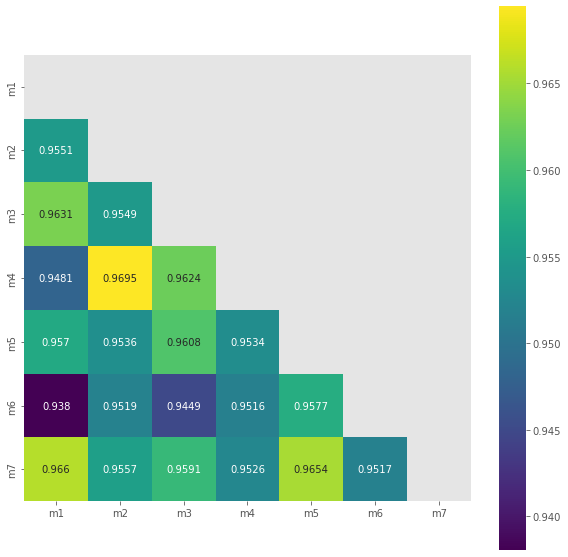

In [37]:
corr = oof_predictions.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

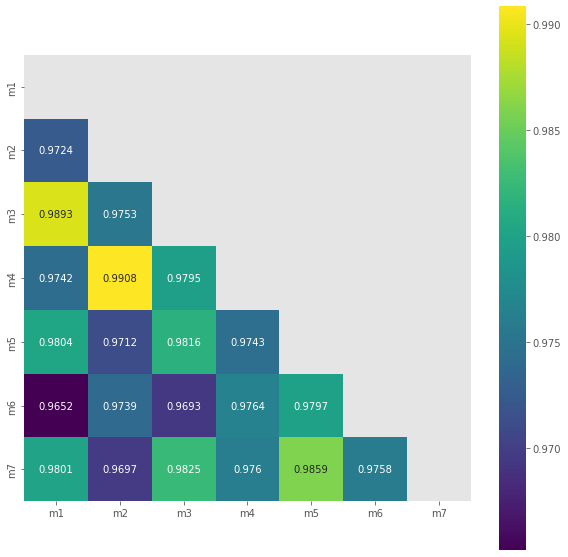

In [38]:
corr = test_probs.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

In [72]:
mean_scores(oof_predictions, y)

AMean score: 0.73233
GMean score: 0.73236
Rank  score: 0.73243
GMean  rank: 0.73243


In [40]:
lda = LinearDiscriminantAnalysis(
                                 solver='eigen',  # lsqr: same LB score
                                 shrinkage='auto',
                                 store_covariance=True,
                                 n_components=1
                                )

estimators_lda, oof_preds_lda, mean_score = cross_validation(model=lda,
                                                             X=oof_predictions,
                                                             y=y,
                                                             cv=KFold(n_splits=10, shuffle=True, random_state=seed))

Fold 1, Train score: 0.73061, Valid score = 0.74871
Fold 2, Train score: 0.73137, Valid score = 0.74279
Fold 3, Train score: 0.73269, Valid score = 0.72872
Fold 4, Train score: 0.73300, Valid score = 0.72740
Fold 5, Train score: 0.73172, Valid score = 0.73742
Fold 6, Train score: 0.73284, Valid score = 0.72975
Fold 7, Train score: 0.73145, Valid score = 0.74154
Fold 8, Train score: 0.73280, Valid score = 0.72821
Fold 9, Train score: 0.73315, Valid score = 0.72579
Fold 10, Train score: 0.73424, Valid score = 0.71511
Train score by each fold: [0.73061, 0.73137, 0.73269, 0.733, 0.73172, 0.73284, 0.73145, 0.7328, 0.73315, 0.73424]
Valid score by each fold: [0.74871, 0.74279, 0.72872, 0.7274, 0.73742, 0.72975, 0.74154, 0.72821, 0.72579, 0.71511]
Train mean score by each fold:0.73239 +/- 0.00102
Valid mean score by each fold:0.73254 +/- 0.00942
**************************************************


In [89]:
test_fin = np.array([estimator.predict_proba(test_probs)[:,1] for estimator in estimators_lda]).T
test_fin = pd.DataFrame(data=test_fin)
#test_fin = np.average(test_fin, axis=1)
test_fin = stats.gmean(test_fin, axis=1)

In [90]:
# 0.73420 on 7 models
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.91M [00:00<?, ?B/s]
  4%|4         | 216k/4.91M [00:00<00:03, 1.38MB/s]
 25%|##5       | 1.23M/4.91M [00:00<00:00, 5.53MB/s]
 38%|###7      | 1.84M/4.91M [00:00<00:01, 3.07MB/s]
 66%|######5   | 3.23M/4.91M [00:00<00:00, 5.54MB/s]
 99%|#########9| 4.88M/4.91M [00:00<00:00, 8.20MB/s]
100%|##########| 4.91M/4.91M [00:02<00:00, 2.46MB/s]


In [47]:
# 0.73393: on 7 models
test_fin = stats.gmean(test_probs, axis=1)
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  4%|4         | 216k/4.90M [00:00<00:03, 1.29MB/s]
 40%|###9      | 1.95M/4.90M [00:00<00:00, 8.58MB/s]
 60%|#####9    | 2.92M/4.90M [00:00<00:00, 4.27MB/s]
 74%|#######3  | 3.61M/4.90M [00:00<00:00, 4.86MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 1.89MB/s]


In [42]:
oof_total_scores = stats.gmean(oof_predictions, axis=1)
stability = create_bootstrap_metrics(y, oof_total_scores, roc_auc_score)

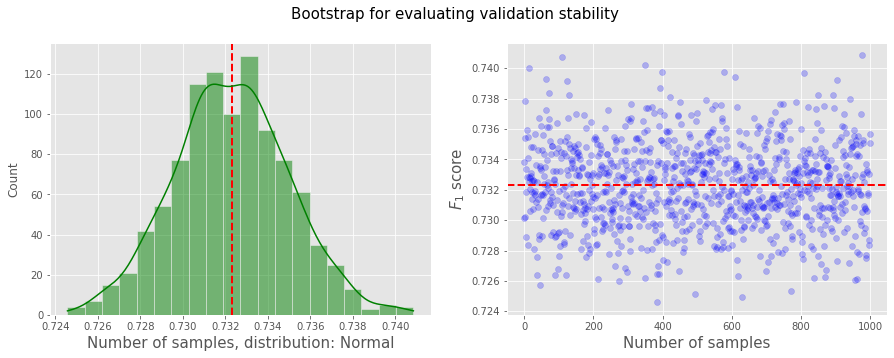

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(stability)), stability, alpha=0.25, color="blue")
axes[1].set_xlabel("Number of samples", size=15)
axes[1].set_ylabel("$F_1$ score", size=15)
distribution = "Normal" if stats.shapiro(stability)[1] >= 0.05 else "Not normal"

axes[0].axvline(np.mean(stability), lw=2, ls='--', c='red')
axes[1].axhline(np.mean(stability), lw=2, ls='--', c='red')
sns.histplot(stability, ax=axes[0], color="green", bins=20, kde=True)
axes[0].set_xlabel(f"Number of samples, distribution: {distribution}", size=15)
plt.show()

In [46]:
# optimization with gmean: 0.73348

results_list = []   
weights_list = []  
preds = oof_predictions.values

def weights_objective(weights):
    # y_ens = np.average(preds, axis=1, weights=weights)
    y_ens = stats.gmean(preds, axis=1, weights=weights)
    return roc_auc_score(y, y_ens)

for k in range(100):
  
    w0 = np.random.uniform(size=preds.shape[1])
    bounds = [(0,1)] * preds.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    results_list.append(res.fun)
    weights_list.append(res.x)

best_score = np.max(results_list)    
best_weights = weights_list[results_list.index(best_score)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score))  # 0.73395 with gmean on test_scores


Optimized weights:
Best score: 0.7328


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

logreg = LogisticRegression(class_weight=None, 
                            solver='liblinear', 
                            penalty='l2', 
                            C=0.1, 
                            random_state=seed,
                            n_jobs=-1)

pipe = make_pipeline(PCA(n_components=6, random_state=seed), logreg)

estimators_log, oof_preds_log, mean_score_log = cross_validation(model=pipe,
                                                                 X=oof_predictions,
                                                                 y=y,
                                                                 cv=KFold(n_splits=10, shuffle=True, random_state=seed))

Fold 1, Train score: 0.73055, Valid score = 0.74906
Fold 2, Train score: 0.73120, Valid score = 0.74344
Fold 3, Train score: 0.73252, Valid score = 0.73039
Fold 4, Train score: 0.73294, Valid score = 0.72688
Fold 5, Train score: 0.73176, Valid score = 0.73674
Fold 6, Train score: 0.73274, Valid score = 0.72926
Fold 7, Train score: 0.73132, Valid score = 0.74129
Fold 8, Train score: 0.73270, Valid score = 0.72867
Fold 9, Train score: 0.73295, Valid score = 0.72647
Fold 10, Train score: 0.73417, Valid score = 0.71613
Train score by each fold: [0.73055, 0.7312, 0.73252, 0.73294, 0.73176, 0.73274, 0.73132, 0.7327, 0.73295, 0.73417]
Valid score by each fold: [0.74906, 0.74344, 0.73039, 0.72688, 0.73674, 0.72926, 0.74129, 0.72867, 0.72647, 0.71613]
Train mean score by each fold:0.73228 +/- 0.00101
Valid mean score by each fold:0.73283 +/- 0.00924
**************************************************


In [49]:
test_fin = np.array([estimator.predict_proba(test_probs)[:,1] for estimator in estimators_log]).T
test_fin = pd.DataFrame(data=test_fin)
test_fin = np.average(test_fin, axis=1)

In [50]:
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})  # 0.73397 on LB
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis


  0%|          | 0.00/4.89M [00:00<?, ?B/s]
  4%|4         | 208k/4.89M [00:00<00:03, 1.50MB/s]
 34%|###4      | 1.68M/4.89M [00:00<00:00, 7.94MB/s]
 51%|#####1    | 2.50M/4.89M [00:00<00:00, 3.86MB/s]
 80%|#######9  | 3.91M/4.89M [00:00<00:00, 6.05MB/s]
100%|##########| 4.89M/4.89M [00:02<00:00, 2.33MB/s]


**Merge part 1 and part 2**

In [57]:
nonzero = pd.read_csv('nonzero.csv')
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})

In [58]:
fin_sub = fin_sub.merge(nonzero, on=ID_COL, how='left')

In [59]:
# fin_sub[TARGET] = np.where(fin_sub['TARGET_y'].isna(), fin_sub['TARGET_x'], fin_sub['TARGET_y'])  # 0.73289

fin_sub[TARGET] = (fin_sub['TARGET_x'] * fin_sub['TARGET_y'])**(1/2)  # 0.73371
fin_sub.loc[fin_sub[TARGET].isna(), TARGET] = fin_sub.loc[fin_sub[TARGET].isna(), 'TARGET_x']

In [60]:
fin_sub.drop(['TARGET_y', 'TARGET_x'], axis=1, inplace=True)

In [61]:
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.74M [00:00<?, ?B/s]
  4%|4         | 208k/4.74M [00:00<00:03, 1.23MB/s]
  7%|6         | 336k/4.74M [00:00<00:08, 538kB/s] 
 13%|#2        | 624k/4.74M [00:00<00:04, 1.05MB/s]
 20%|##        | 992k/4.74M [00:00<00:02, 1.67MB/s]
 28%|##7       | 1.31M/4.74M [00:00<00:01, 2.13MB/s]
 35%|###4      | 1.64M/4.74M [00:00<00:01, 2.45MB/s]
 42%|####1     | 1.98M/4.74M [00:01<00:01, 2.75MB/s]
 48%|####8     | 2.30M/4.74M [00:01<00:00, 2.90MB/s]
 56%|#####5    | 2.65M/4.74M [00:01<00:00, 3.09MB/s]
 63%|######3   | 2.99M/4.74M [00:01<00:00, 3.19MB/s]
 70%|#######   | 3.34M/4.74M [00:01<00:00, 3.30MB/s]
 79%|#######8  | 3.73M/4.74M [00:01<00:00, 3.52MB/s]
 87%|########7 | 4.14M/4.74M [00:01<00:00, 3.71MB/s]
 97%|#########6| 4.59M/4.74M [00:01<00:00, 3.92MB/s]
100%|##########| 4.74M/4.74M [00:03<00:00, 1.62MB/s]


### Feature selection

In [108]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [109]:
X_inspect = pd.concat([x_train, x_test], axis=0)
y_inspect = np.hstack((np.ones(x_train.shape[0]), np.zeros(x_test.shape[0])))

inspector = LGBMClassifier(max_depth=4, 
                           n_estimators=100,
                           verbose=-1,
                           is_unbalance=True,
                           learning_rate=0.05,   
                           random_seed=seed).fit(X_inspect, y_inspect)

cv = cross_val_score(
    estimator=inspector,
    X=X_inspect, y=y_inspect,
    scoring="roc_auc",
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5004


In [111]:
scores, deltas = calculate_permutation_importance(LGBMClassifier(**lgbm_params_my).fit(x_train, y_train), 
                                                  x_valid=x_test, 
                                                  y_valid=y_test,
                                                  probas=True, 
                                                  metric=roc_auc_score)

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:33<00:00,  3.51it/s]


In [116]:
perm = deltas[deltas >= 0].index.tolist()

In [133]:
perm = perm + ["EXTERNAL_SCORE_WEIGHTED", "EXTERNAL_SCORING_RATING_1"]

In [142]:
# select best feature set by exhaustive method
lgbm_params_my = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 1000,
                'learning_rate': 0.03,
                'num_leaves': 42,
                'max_depth': 10,
                'reg_alpha': 0.05,
                'reg_lambda': 0.06,
                'subsample': 0.8,
                'min_child_weight': 60,
                'random_state': seed
}

best_selector = BestSet(lgbm_params_my, k_features=40).fit(X[perm], y)

In [ ]:
max(best_selector.scores_), X[perm][list(best_selector.subsets_[np.argmax(best_selector.scores_)])]

In [153]:
X[perm].columns[list(best_selector.subsets_[np.argmax(best_selector.scores_)])], max(best_selector.scores_)

(Index(['EXT_SCORES_mean', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'ANNUITY_JOB',
        'EXTERNAL_SCORING_RATING_3', 'NAME_CONTRACT_TYPE',
        'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'AMOUNT_ANNUITY',
        'EXTERNAL_SCORING_RATING_2', 'AGE', 'AMT_REQ_CREDIT_BUREAU_QRT',
        'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'TOTAL_SALARY_COUNT_AGE_INTERVAL',
        'EDUCATION_FAMILY_STATUS', 'TOTAL_SALARY_MEAN_AGE_INTERVAL',
        'AMOUNT_CREDIT', 'RATIO_AGE_TO_EXPERIENCE', 'RATIO_CAR_TO_AGE',
        'EXT_SCORES_min', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY',
        'AMOUNT_CREDIT_MEAN_AGE_INTERVAL',
        'AMOUNT_ANNUITY_MIN_BY_FAMILY_STATUS', 'RATIO_CREDIT_TO_AGE',
        'TOTAL_SALARY_MAX_AGE_INTERVAL', 'NEW_STATUS_MSeparated',
        'EXT_SCORE_3_ANNUITY', 'NEW_STATUS_MMarried',
        'TOTAL_SALARY_MEAN_BY_EDUCATION',
        'DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION',
        'AMT_REQ_CREDIT_BUREAU_YEAR', 'CHILDRENS',
        'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'TOTAL_SAL

#### Watch profile features combinations (fillna before add, multiply, etc.) - new ipynb - did not work
#### target encoding did not work
#### adding history features did not work

### PART I 

Train CV ensemble models on existing profile data only with hold-out set, CI.

Combine part I and part II: replace samples scores, amean, gmean

### Optuna search